In [3]:
!pip install pandasql

  Preparing metadata (setup.py) ... done
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26772 sha256=d7654860664e4badf1c15cebf633dd18b85b81e092a11abb84ae81a8648050d6
  Stored in directory: /root/.cache/pip/wheels/68/5d/a5/edc271b998f909801d7956959f699b976cc9896075dc47c153
Successfully built pandasql


In [28]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pandasql as ps
import math
import warnings
import itertools
import random
import statsmodels.api as sm

# time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
#matplotlib libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors
import seaborn as sns
import seaborn as sns
#date libraries
from dateutil import parser
from datetime import datetime, timedelta, date
import holidays
#prophet library
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import cross_validation
#pandas options
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#matplotlib setting defaults
sns.set(font="Arial",
        rc={
 "axes.axisbelow": False,
 "axes.edgecolor": "lightgrey",
 "axes.facecolor": "None",
 "axes.grid": False,
 "axes.labelcolor": "dimgrey",
 "axes.spines.right": False,
 "axes.spines.top": False,
 "figure.facecolor": "white",
 "lines.solid_capstyle": "round",
 "patch.edgecolor": "w",
 "patch.force_edgecolor": True,
 "text.color": "dimgrey",
 "xtick.bottom": False,
 "xtick.color": "dimgrey",
 "xtick.direction": "out",
 "xtick.top": False,
 "ytick.color": "dimgrey",
 "ytick.direction": "out",
 "ytick.left": False,
 "ytick.right": False})
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

In [29]:
# Mean Absolut Percent Error
def mape(actual, pred):
    '''
    Mean Absolute Percentage Error (MAPE) Function

    input: list/series for actual values and predicted values
    output: mape value
    '''
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [30]:
from google.colab import files
uploaded = files.upload()

Saving 20-25 Sales .csv to 20-25 Sales  (3).csv


In [31]:
# Load Data
file_path = "20-25 Sales .csv"
df = pd.read_csv(file_path)

df.head()

,Date,Sales
0,7/20/20,0
1,8/1/20,11
2,9/1/20,31
3,10/1/20,46
4,11/1/20,31


In [32]:
#Exclude rows that contain 0 sales
df = df[df['Sales']!=0]

In [33]:
# Change the ds column to datetime for prophet
df['Date']=pd.to_datetime(df['Date'])
df.dtypes

,0
Date,datetime64[ns]
Sales,int64


In [34]:
# Find the minimum and maximum date
start = min(df['Date'])
end = max(df['Date'])
print(start,end)

2020-08-01 00:00:00 2025-01-01 00:00:00


In [35]:
# Rename a single column
df.rename(columns={'Date': 'ds','Sales': 'y'}, inplace=True)

In [36]:
#Adding holiday data

holiday = pd.DataFrame([])

us_holidays = holidays.US()

us_holidays = holidays.country_holidays('US')


for date_, name in sorted(holidays.US(years=[2023.2024]).items()):
    holiday = pd.concat([holiday, pd.DataFrame({'ds': date_, 'holiday': "US-Holidays", 'lower_window': -2, 'upper_window': 1}, index=[0])], ignore_index=True)

holiday['Date'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')
holiday.head()

,ds,holiday,lower_window,upper_window,Date
0,2023-01-01,US-Holidays,-2,1,2023-01-01
1,2023-01-02,US-Holidays,-2,1,2023-01-02
2,2023-01-16,US-Holidays,-2,1,2023-01-16
3,2023-02-20,US-Holidays,-2,1,2023-02-20
4,2023-05-29,US-Holidays,-2,1,2023-05-29


Run Simple Prophet Model

In [38]:
#Set the uncertainty interval to 95%. (defalut is 80%)
model = Prophet()
model.fit(df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/hy82nbpe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/t3ckjumx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28992', 'data', 'file=/tmp/tmpstg6ceuj/hy82nbpe.json', 'init=/tmp/tmpstg6ceuj/t3ckjumx.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modelfnye6foh/prophet_model-20250228015426.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
01:54:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:54:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [41]:
future = model.make_future_dataframe(periods=12, freq="MS")
future.tail()

,ds
61,2025-09-01
62,2025-10-01
63,2025-11-01
64,2025-12-01
65,2026-01-01


In [42]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
59,2025-07-01,133.47,117.95,148.87
60,2025-08-01,128.34,114.29,144.64
61,2025-09-01,128.78,113.11,144.48
62,2025-10-01,143.39,127.70,159.71
63,2025-11-01,126.74,111.73,142.67
64,2025-12-01,127.01,111.39,141.70
65,2026-01-01,136.02,119.89,150.82


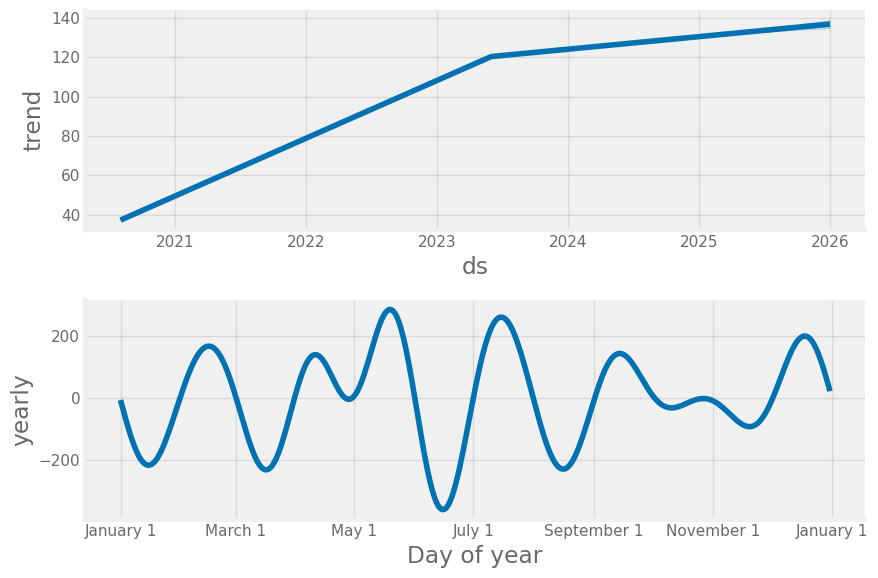

In [43]:
# Plot the components of the model
fig = model.plot_components(forecast)

In [47]:
#Train/Test
split_date = pd.to_datetime('2023-01-01')
X_tr = df[df['ds'] <= split_date]
X_tst = df[df['ds'] > split_date]

In [48]:
X_tst_forecast = model.predict(X_tst)
X_tst_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
17,2024-07-01,135.09,119.73,152.05
18,2024-08-01,116.07,101.57,132.27
19,2024-09-01,127.37,111.02,141.95
20,2024-10-01,134.98,118.46,151.43
21,2024-11-01,119.61,103.88,134.45
22,2024-12-01,124.23,109.83,140.36
23,2025-01-01,123.87,107.86,138.72


Hypertuning Inclusions
1. Holidays
2. Changepoints: (n_changepoints,changepoint_prior_scale)
3. seasonality_mode
4. holiday_prior_scale
5. Seasonalities with fourier_order



In [49]:
#HyperParameter tuning using Parameter Grid
from sklearn.model_selection import ParameterGrid
params_grid = {'seasonality_mode':('multiplicative','additive'),
               'changepoint_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'holidays_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'n_changepoints' : [100,150,200]}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

Total Possible Models 150


In [56]:
# Prophet Model Tuning
strt= start
end= end
model_parameters = pd.DataFrame(columns = ['mape','Parameters'])
for p in grid:
    test = pd.DataFrame()
    print(p)
    random.seed(0)
    train_model =Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                         holidays_prior_scale = p['holidays_prior_scale'],
                         n_changepoints = p['n_changepoints'],
                         seasonality_mode = p['seasonality_mode'],
                         weekly_seasonality=True,
                         daily_seasonality = True,
                         yearly_seasonality = True,
                         holidays=holiday,
                         interval_width=0.95)
    train_model.add_country_holidays(country_name='US')
    train_model.fit(X_tr)
    train_forecast = train_model.make_future_dataframe(periods=53, freq='MS',include_history = False)
    train_forecast = train_model.predict(train_forecast)
    test=train_forecast[['ds','yhat']]
    Actual = df[(df['ds']>strt) & (df['ds']<=end)]
    MAPE = mape(Actual['y'],abs(test['yhat']))
    print('Mean Absolute Percentage Error(mape)------------------------------------',mape)
    model_parameters = pd.concat([model_parameters, pd.DataFrame([{'mape':MAPE,'Parameters':p}])],ignore_index=True)

INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/fk_q5jh1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/s_j3iddd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59948', 'data', 'file=/tmp/tmpstg6ceuj/fk_q5jh1.json', 'init=/tmp/tmpstg6ceuj/s_j3iddd.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_model0khbdaem/prophet_model-20250228021028.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:10:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


02:10:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/jm6wk7_5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/821wsm5r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50717', 'data', 'file=/tmp/tmpstg6ceuj/jm6wk7_5.json', 'init=/tmp/tmpstg6ceuj/821wsm5r.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modelurvskh64/prophet_model-20250228021031.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:10:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


02:10:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/6f4z5kyf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/ul6k43c2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79795', 'data', 'file=/tmp/tmpstg6ceuj/6f4z5kyf.json', 'init=/tmp/tmpstg6ceuj/ul6k43c2.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modelvqcht077/prophet_model-20250228021034.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:10:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


02:10:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/be4eujsq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/wtxctx9y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90569', 'data', 'file=/tmp/tmpstg6ceuj/be4eujsq.json', 'init=/tmp/tmpstg6ceuj/wtxctx9y.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modelwkw6p6_3/prophet_model-20250228021037.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:10:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


02:10:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/pxc255tu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/rmg2dl8y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2771', 'data', 'file=/tmp/tmpstg6ceuj/pxc255tu.json', 'init=/tmp/tmpstg6ceuj/rmg2dl8y.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modelx14x12nq/prophet_model-20250228021039.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:10:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


02:10:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/kuqxc95u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/klr6wxjz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61090', 'data', 'file=/tmp/tmpstg6ceuj/kuqxc95u.json', 'init=/tmp/tmpstg6ceuj/klr6wxjz.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modelung5rmq6/prophet_model-20250228021043.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:10:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


02:10:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/qquju47r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/j2xkws21.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65790', 'data', 'file=/tmp/tmpstg6ceuj/qquju47r.json', 'init=/tmp/tmpstg6ceuj/j2xkws21.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modelh__ysq7x/prophet_model-20250228021045.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:10:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


02:10:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/fr6kkwat.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/fz4yawtd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33893', 'data', 'file=/tmp/tmpstg6ceuj/fr6kkwat.json', 'init=/tmp/tmpstg6ceuj/fz4yawtd.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modellufgio3v/prophet_model-20250228021048.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:10:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


02:10:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/gj3y308c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/axn1h2uh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34714', 'data', 'file=/tmp/tmpstg6ceuj/gj3y308c.json', 'init=/tmp/tmpstg6ceuj/axn1h2uh.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modeljjusta0h/prophet_model-20250228021051.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:10:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


02:10:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/tjmlf0u3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/998m8jz1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56651', 'data', 'file=/tmp/tmpstg6ceuj/tjmlf0u3.json', 'init=/tmp/tmpstg6ceuj/998m8jz1.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modelr_ff87eg/prophet_model-20250228021055.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:10:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


02:10:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/c7rjyy2k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/t68nti4e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68507', 'data', 'file=/tmp/tmpstg6ceuj/c7rjyy2k.json', 'init=/tmp/tmpstg6ceuj/t68nti4e.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modelef0s6vwi/prophet_model-20250228021057.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:10:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


02:11:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/ilwab9gf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/7b9tgl0i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59297', 'data', 'file=/tmp/tmpstg6ceuj/ilwab9gf.json', 'init=/tmp/tmpstg6ceuj/7b9tgl0i.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modellkwtwe3o/prophet_model-20250228021100.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:11:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


02:11:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/w5l89xlk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/qrikpnjx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18276', 'data', 'file=/tmp/tmpstg6ceuj/w5l89xlk.json', 'init=/tmp/tmpstg6ceuj/qrikpnjx.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modelbu5127rn/prophet_model-20250228021103.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:11:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


02:11:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/8u5ytuhs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/liujdp_p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63831', 'data', 'file=/tmp/tmpstg6ceuj/8u5ytuhs.json', 'init=/tmp/tmpstg6ceuj/liujdp_p.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modelljeu17bk/prophet_model-20250228021105.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:11:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


02:11:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/9c1o5wyw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/vn91kswt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26176', 'data', 'file=/tmp/tmpstg6ceuj/9c1o5wyw.json', 'init=/tmp/tmpstg6ceuj/vn91kswt.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_model5yb_ghfl/prophet_model-20250228021108.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:11:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


02:11:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/scbv9yzy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/whjdt1ru.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16163', 'data', 'file=/tmp/tmpstg6ceuj/scbv9yzy.json', 'init=/tmp/tmpstg6ceuj/whjdt1ru.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modelxlxlu1nl/prophet_model-20250228021110.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:11:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


02:11:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/vz_uu0uf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/b2defl0k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11900', 'data', 'file=/tmp/tmpstg6ceuj/vz_uu0uf.json', 'init=/tmp/tmpstg6ceuj/b2defl0k.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modelie_6rz85/prophet_model-20250228021113.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:11:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


02:11:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/r7aemebw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/v8p3hmvz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53242', 'data', 'file=/tmp/tmpstg6ceuj/r7aemebw.json', 'init=/tmp/tmpstg6ceuj/v8p3hmvz.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modeldqa6o51_/prophet_model-20250228021114.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:11:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


02:11:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/snj02dqy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/o9p5jo_5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81377', 'data', 'file=/tmp/tmpstg6ceuj/snj02dqy.json', 'init=/tmp/tmpstg6ceuj/o9p5jo_5.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modela9iupcq3/prophet_model-20250228021117.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:11:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


02:11:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/3o3jka0z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/zh2pwzwz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1424', 'data', 'file=/tmp/tmpstg6ceuj/3o3jka0z.json', 'init=/tmp/tmpstg6ceuj/zh2pwzwz.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_model6l1ce9lp/prophet_model-20250228021121.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:11:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


02:11:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/x68_q0vz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/20i7g49x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16023', 'data', 'file=/tmp/tmpstg6ceuj/x68_q0vz.json', 'init=/tmp/tmpstg6ceuj/20i7g49x.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modelf515c97o/prophet_model-20250228021123.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:11:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


02:11:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/nu0clann.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/0j7gb_0i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75372', 'data', 'file=/tmp/tmpstg6ceuj/nu0clann.json', 'init=/tmp/tmpstg6ceuj/0j7gb_0i.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modelloupgm2g/prophet_model-20250228021126.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:11:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


02:11:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/w9a1bjyw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/h5jvu4lj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11133', 'data', 'file=/tmp/tmpstg6ceuj/w9a1bjyw.json', 'init=/tmp/tmpstg6ceuj/h5jvu4lj.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_model9mreln9m/prophet_model-20250228021128.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:11:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


02:11:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/i6bwh9fo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/zfr3jgxw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96', 'data', 'file=/tmp/tmpstg6ceuj/i6bwh9fo.json', 'init=/tmp/tmpstg6ceuj/zfr3jgxw.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modelhwt6hgiy/prophet_model-20250228021132.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:11:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


02:11:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/ixb29bl5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/xydy7zxu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11774', 'data', 'file=/tmp/tmpstg6ceuj/ixb29bl5.json', 'init=/tmp/tmpstg6ceuj/xydy7zxu.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modell94ylmdt/prophet_model-20250228021134.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:11:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


02:11:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/c1nl3s24.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/j908ah7o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39007', 'data', 'file=/tmp/tmpstg6ceuj/c1nl3s24.json', 'init=/tmp/tmpstg6ceuj/j908ah7o.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modelv0fyd80p/prophet_model-20250228021136.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:11:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


02:11:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/2b9a4k50.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/p9a1lvk0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51068', 'data', 'file=/tmp/tmpstg6ceuj/2b9a4k50.json', 'init=/tmp/tmpstg6ceuj/p9a1lvk0.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modelq1lt4cpo/prophet_model-20250228021138.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:11:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


02:11:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/w6c425m2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/076t2xlt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34320', 'data', 'file=/tmp/tmpstg6ceuj/w6c425m2.json', 'init=/tmp/tmpstg6ceuj/076t2xlt.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modeliilzblk5/prophet_model-20250228021140.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:11:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


02:11:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/1quajhsi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/x5lac9s3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32143', 'data', 'file=/tmp/tmpstg6ceuj/1quajhsi.json', 'init=/tmp/tmpstg6ceuj/x5lac9s3.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_model4vuwusao/prophet_model-20250228021142.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:11:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


02:11:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/djwws9sj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/f_4jx_ne.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30951', 'data', 'file=/tmp/tmpstg6ceuj/djwws9sj.json', 'init=/tmp/tmpstg6ceuj/f_4jx_ne.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_model81r2wc74/prophet_model-20250228021145.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:11:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


02:11:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/p_bed7er.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/y7xilx69.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90969', 'data', 'file=/tmp/tmpstg6ceuj/p_bed7er.json', 'init=/tmp/tmpstg6ceuj/y7xilx69.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modelgspf3t1q/prophet_model-20250228021147.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:11:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


02:11:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/l4t6k5f3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/utao4cpp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86822', 'data', 'file=/tmp/tmpstg6ceuj/l4t6k5f3.json', 'init=/tmp/tmpstg6ceuj/utao4cpp.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_model1xkl9lc2/prophet_model-20250228021149.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:11:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


02:11:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/wd15xywp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/nrkaszfq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59509', 'data', 'file=/tmp/tmpstg6ceuj/wd15xywp.json', 'init=/tmp/tmpstg6ceuj/nrkaszfq.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modelylvf4f7p/prophet_model-20250228021152.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:11:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


02:11:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/9d2op8f3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/ig2isoru.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46421', 'data', 'file=/tmp/tmpstg6ceuj/9d2op8f3.json', 'init=/tmp/tmpstg6ceuj/ig2isoru.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modelsawbo226/prophet_model-20250228021154.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:11:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


02:11:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/5ps7f8qu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/bn7tbw1j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94704', 'data', 'file=/tmp/tmpstg6ceuj/5ps7f8qu.json', 'init=/tmp/tmpstg6ceuj/bn7tbw1j.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_model54dauw5o/prophet_model-20250228021158.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:11:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


02:12:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/bl6x4km9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/7k7s1snq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54848', 'data', 'file=/tmp/tmpstg6ceuj/bl6x4km9.json', 'init=/tmp/tmpstg6ceuj/7k7s1snq.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_model7kx3j9co/prophet_model-20250228021200.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:12:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


02:12:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/g4up0pqk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/mkq0hbii.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8355', 'data', 'file=/tmp/tmpstg6ceuj/g4up0pqk.json', 'init=/tmp/tmpstg6ceuj/mkq0hbii.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modele53qzg56/prophet_model-20250228021203.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:12:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


02:12:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/i3f61_yz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/76u1gyfs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38851', 'data', 'file=/tmp/tmpstg6ceuj/i3f61_yz.json', 'init=/tmp/tmpstg6ceuj/76u1gyfs.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modeluoybdrnl/prophet_model-20250228021207.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:12:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


02:12:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/o8h3zsqq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/n3vchoe9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62659', 'data', 'file=/tmp/tmpstg6ceuj/o8h3zsqq.json', 'init=/tmp/tmpstg6ceuj/n3vchoe9.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_model__due20a/prophet_model-20250228021209.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:12:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


02:12:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/l_o9lhlh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/rjfhmzex.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95490', 'data', 'file=/tmp/tmpstg6ceuj/l_o9lhlh.json', 'init=/tmp/tmpstg6ceuj/rjfhmzex.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_model2uwc9joj/prophet_model-20250228021214.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:12:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


02:12:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/vjuqqg_0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/2irlcgeq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34478', 'data', 'file=/tmp/tmpstg6ceuj/vjuqqg_0.json', 'init=/tmp/tmpstg6ceuj/2irlcgeq.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modelyawcwkpi/prophet_model-20250228021215.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:12:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


02:12:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/wuilhjeg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/yr7rdckv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90', 'data', 'file=/tmp/tmpstg6ceuj/wuilhjeg.json', 'init=/tmp/tmpstg6ceuj/yr7rdckv.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modelvv2eppgv/prophet_model-20250228021219.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:12:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


02:12:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/wccg0a30.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/uq5mawja.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31117', 'data', 'file=/tmp/tmpstg6ceuj/wccg0a30.json', 'init=/tmp/tmpstg6ceuj/uq5mawja.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modelm3wn3h44/prophet_model-20250228021221.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:12:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


02:12:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/__hp6_ld.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/4_7mxmgj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74997', 'data', 'file=/tmp/tmpstg6ceuj/__hp6_ld.json', 'init=/tmp/tmpstg6ceuj/4_7mxmgj.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modelx01dy_en/prophet_model-20250228021225.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:12:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


02:12:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/u3hmhqar.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/s3lml97q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11291', 'data', 'file=/tmp/tmpstg6ceuj/u3hmhqar.json', 'init=/tmp/tmpstg6ceuj/s3lml97q.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modelpii6vmwt/prophet_model-20250228021227.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:12:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


02:12:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/2hvqtpq4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/rnl7ccq3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67572', 'data', 'file=/tmp/tmpstg6ceuj/2hvqtpq4.json', 'init=/tmp/tmpstg6ceuj/rnl7ccq3.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modelnxzoccym/prophet_model-20250228021231.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:12:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


02:12:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/4icmy4lq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/cmuaimdw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15800', 'data', 'file=/tmp/tmpstg6ceuj/4icmy4lq.json', 'init=/tmp/tmpstg6ceuj/cmuaimdw.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_model0pmmeia8/prophet_model-20250228021233.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:12:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


02:12:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/un8dszka.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/7ox23okz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86014', 'data', 'file=/tmp/tmpstg6ceuj/un8dszka.json', 'init=/tmp/tmpstg6ceuj/7ox23okz.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modelfngald3q/prophet_model-20250228021237.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:12:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


02:12:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/5kjjnal4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/ipxe3_k5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=218', 'data', 'file=/tmp/tmpstg6ceuj/5kjjnal4.json', 'init=/tmp/tmpstg6ceuj/ipxe3_k5.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modellqgv6elk/prophet_model-20250228021239.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:12:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


02:12:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/eleqpvwz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/kr8di_sk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1977', 'data', 'file=/tmp/tmpstg6ceuj/eleqpvwz.json', 'init=/tmp/tmpstg6ceuj/kr8di_sk.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_model9w9zqzhy/prophet_model-20250228021241.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:12:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


02:12:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/7nedij6f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/2c0zpbk4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42094', 'data', 'file=/tmp/tmpstg6ceuj/7nedij6f.json', 'init=/tmp/tmpstg6ceuj/2c0zpbk4.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modelfa0dfbsh/prophet_model-20250228021244.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:12:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


02:12:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/p7873jdu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/n4xusewn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77093', 'data', 'file=/tmp/tmpstg6ceuj/p7873jdu.json', 'init=/tmp/tmpstg6ceuj/n4xusewn.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_model12uekqx3/prophet_model-20250228021245.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:12:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


02:12:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/thlc1ah1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/vhqikhig.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45214', 'data', 'file=/tmp/tmpstg6ceuj/thlc1ah1.json', 'init=/tmp/tmpstg6ceuj/vhqikhig.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modelottqi7gu/prophet_model-20250228021249.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:12:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


02:12:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/dkd3aizb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/pgpvane3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36071', 'data', 'file=/tmp/tmpstg6ceuj/dkd3aizb.json', 'init=/tmp/tmpstg6ceuj/pgpvane3.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modelqq5lvvtb/prophet_model-20250228021251.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:12:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


02:12:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/a6ykhlta.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/ou5h6rr0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29009', 'data', 'file=/tmp/tmpstg6ceuj/a6ykhlta.json', 'init=/tmp/tmpstg6ceuj/ou5h6rr0.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modelqpda0e9o/prophet_model-20250228021254.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:12:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


02:12:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/ij6znapy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/ekezjjdx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86692', 'data', 'file=/tmp/tmpstg6ceuj/ij6znapy.json', 'init=/tmp/tmpstg6ceuj/ekezjjdx.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_model60mkfxu2/prophet_model-20250228021256.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:12:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


02:12:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/padl317x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/i0dc4io2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37690', 'data', 'file=/tmp/tmpstg6ceuj/padl317x.json', 'init=/tmp/tmpstg6ceuj/i0dc4io2.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modelup1heciu/prophet_model-20250228021259.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:12:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


02:13:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/_1nsopua.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/ofat98q6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23809', 'data', 'file=/tmp/tmpstg6ceuj/_1nsopua.json', 'init=/tmp/tmpstg6ceuj/ofat98q6.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_model3opw3y01/prophet_model-20250228021303.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:13:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


02:13:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/vr03zvzd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/w__v8bel.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79423', 'data', 'file=/tmp/tmpstg6ceuj/vr03zvzd.json', 'init=/tmp/tmpstg6ceuj/w__v8bel.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modelj6y9c0uz/prophet_model-20250228021305.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:13:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


02:13:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/0o__p996.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/v3qs89vh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65591', 'data', 'file=/tmp/tmpstg6ceuj/0o__p996.json', 'init=/tmp/tmpstg6ceuj/v3qs89vh.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_model7cpyfjkv/prophet_model-20250228021308.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:13:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


02:13:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/rtbqop56.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/7w_ivvco.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21880', 'data', 'file=/tmp/tmpstg6ceuj/rtbqop56.json', 'init=/tmp/tmpstg6ceuj/7w_ivvco.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modelocebx9so/prophet_model-20250228021310.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:13:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


02:13:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/tq7x1u_a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/yzqcxa2l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42713', 'data', 'file=/tmp/tmpstg6ceuj/tq7x1u_a.json', 'init=/tmp/tmpstg6ceuj/yzqcxa2l.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modeljof_iy57/prophet_model-20250228021313.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:13:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


02:13:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/sp31c8b1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/jgp3yvpi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1930', 'data', 'file=/tmp/tmpstg6ceuj/sp31c8b1.json', 'init=/tmp/tmpstg6ceuj/jgp3yvpi.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_model6hbcxon1/prophet_model-20250228021321.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:13:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


02:13:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/pm7xi6ak.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/ch9h3g8s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93506', 'data', 'file=/tmp/tmpstg6ceuj/pm7xi6ak.json', 'init=/tmp/tmpstg6ceuj/ch9h3g8s.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_model1cloo4_y/prophet_model-20250228021324.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:13:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


02:13:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/3frhn7of.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/_kdul52w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84666', 'data', 'file=/tmp/tmpstg6ceuj/3frhn7of.json', 'init=/tmp/tmpstg6ceuj/_kdul52w.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modeld1fg8nor/prophet_model-20250228021332.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:13:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


02:13:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/hgo_aim0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/1b6sru0c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65477', 'data', 'file=/tmp/tmpstg6ceuj/hgo_aim0.json', 'init=/tmp/tmpstg6ceuj/1b6sru0c.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_model8opiy9nf/prophet_model-20250228021335.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:13:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


02:13:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/rot_2b60.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/ssge1mt6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96640', 'data', 'file=/tmp/tmpstg6ceuj/rot_2b60.json', 'init=/tmp/tmpstg6ceuj/ssge1mt6.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modelb1rtp_8a/prophet_model-20250228021343.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:13:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


02:13:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/pgxrclcd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/me45s7k5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88839', 'data', 'file=/tmp/tmpstg6ceuj/pgxrclcd.json', 'init=/tmp/tmpstg6ceuj/me45s7k5.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modeln6rruhyt/prophet_model-20250228021346.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:13:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


02:13:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/y9fjpzpc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/lp599ycw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64498', 'data', 'file=/tmp/tmpstg6ceuj/y9fjpzpc.json', 'init=/tmp/tmpstg6ceuj/lp599ycw.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modelekye7r12/prophet_model-20250228021348.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:13:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


02:13:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/vi7engkz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/xxjbypsb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53731', 'data', 'file=/tmp/tmpstg6ceuj/vi7engkz.json', 'init=/tmp/tmpstg6ceuj/xxjbypsb.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modeltpo7hsns/prophet_model-20250228021352.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:13:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


02:13:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/hifms235.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/dhubkiju.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18907', 'data', 'file=/tmp/tmpstg6ceuj/hifms235.json', 'init=/tmp/tmpstg6ceuj/dhubkiju.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modelkrde2vv0/prophet_model-20250228021355.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:13:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


02:13:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/_2v5cjo9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/9z_dlnc9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71893', 'data', 'file=/tmp/tmpstg6ceuj/_2v5cjo9.json', 'init=/tmp/tmpstg6ceuj/9z_dlnc9.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_model4u9kwopn/prophet_model-20250228021358.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:13:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


02:14:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/ndxpsth1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/ur7lihiv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8354', 'data', 'file=/tmp/tmpstg6ceuj/ndxpsth1.json', 'init=/tmp/tmpstg6ceuj/ur7lihiv.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modelj4i8lb45/prophet_model-20250228021400.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:14:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


02:14:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/r8g1dkc1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/_f9solld.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38377', 'data', 'file=/tmp/tmpstg6ceuj/r8g1dkc1.json', 'init=/tmp/tmpstg6ceuj/_f9solld.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modeltraej77a/prophet_model-20250228021403.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:14:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


02:14:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/waacwb5j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/7mta6t6o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5997', 'data', 'file=/tmp/tmpstg6ceuj/waacwb5j.json', 'init=/tmp/tmpstg6ceuj/7mta6t6o.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modelj_p5uvpl/prophet_model-20250228021407.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:14:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


02:14:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/cf5mrljd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/iy9cio1m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68724', 'data', 'file=/tmp/tmpstg6ceuj/cf5mrljd.json', 'init=/tmp/tmpstg6ceuj/iy9cio1m.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_model6vwpkwx6/prophet_model-20250228021410.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:14:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


02:14:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/yg315_81.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/6ge2f2ol.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5343', 'data', 'file=/tmp/tmpstg6ceuj/yg315_81.json', 'init=/tmp/tmpstg6ceuj/6ge2f2ol.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modele9oqrfwt/prophet_model-20250228021412.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:14:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


02:14:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/wuvz8lfe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/4_wtwzjz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76908', 'data', 'file=/tmp/tmpstg6ceuj/wuvz8lfe.json', 'init=/tmp/tmpstg6ceuj/4_wtwzjz.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modeln3rz80rs/prophet_model-20250228021416.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:14:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


02:14:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/gh3q0393.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/6azm1fnx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15536', 'data', 'file=/tmp/tmpstg6ceuj/gh3q0393.json', 'init=/tmp/tmpstg6ceuj/6azm1fnx.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modelv70vu08y/prophet_model-20250228021419.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:14:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


02:14:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/unt8qjsj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/bhsyv0zg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75345', 'data', 'file=/tmp/tmpstg6ceuj/unt8qjsj.json', 'init=/tmp/tmpstg6ceuj/bhsyv0zg.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modelqr3s5ed6/prophet_model-20250228021422.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:14:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


02:14:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/o31li5qs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/xlnyqof_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36634', 'data', 'file=/tmp/tmpstg6ceuj/o31li5qs.json', 'init=/tmp/tmpstg6ceuj/xlnyqof_.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_model2fp3s31f/prophet_model-20250228021425.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:14:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


02:14:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/a1ps40pj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/ytuk7uri.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55852', 'data', 'file=/tmp/tmpstg6ceuj/a1ps40pj.json', 'init=/tmp/tmpstg6ceuj/ytuk7uri.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_model6eaqh70g/prophet_model-20250228021428.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:14:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


02:14:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/84g6njwh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/4fqwpgn_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54188', 'data', 'file=/tmp/tmpstg6ceuj/84g6njwh.json', 'init=/tmp/tmpstg6ceuj/4fqwpgn_.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modelrbzuigb6/prophet_model-20250228021432.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:14:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


02:14:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/gvbg7re5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/_8hikhkq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88545', 'data', 'file=/tmp/tmpstg6ceuj/gvbg7re5.json', 'init=/tmp/tmpstg6ceuj/_8hikhkq.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modelv0nh7wp_/prophet_model-20250228021435.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:14:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


02:14:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/ogt59uid.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/8gfwcnb8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70769', 'data', 'file=/tmp/tmpstg6ceuj/ogt59uid.json', 'init=/tmp/tmpstg6ceuj/8gfwcnb8.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modelnrndb52t/prophet_model-20250228021438.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:14:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


02:14:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/mhmt7bh9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/t3gk593i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9884', 'data', 'file=/tmp/tmpstg6ceuj/mhmt7bh9.json', 'init=/tmp/tmpstg6ceuj/t3gk593i.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modelc3k3jghv/prophet_model-20250228021442.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:14:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


02:14:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/_iai7899.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/8uc89bqi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55982', 'data', 'file=/tmp/tmpstg6ceuj/_iai7899.json', 'init=/tmp/tmpstg6ceuj/8uc89bqi.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modelygtcmqzm/prophet_model-20250228021446.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:14:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


02:14:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/zwwuna0s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/bzluluge.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15264', 'data', 'file=/tmp/tmpstg6ceuj/zwwuna0s.json', 'init=/tmp/tmpstg6ceuj/bzluluge.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modelukbgi_zc/prophet_model-20250228021450.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:14:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


02:14:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/z26c8n9n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/7e_dboyp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81136', 'data', 'file=/tmp/tmpstg6ceuj/z26c8n9n.json', 'init=/tmp/tmpstg6ceuj/7e_dboyp.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modellpcjh_bo/prophet_model-20250228021453.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:14:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


02:14:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/rdprh50q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/3ycfa4xd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=975', 'data', 'file=/tmp/tmpstg6ceuj/rdprh50q.json', 'init=/tmp/tmpstg6ceuj/3ycfa4xd.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_model9zu5ilag/prophet_model-20250228021458.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:14:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.3, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


02:15:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/3kng1bof.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/7f05__u3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84157', 'data', 'file=/tmp/tmpstg6ceuj/3kng1bof.json', 'init=/tmp/tmpstg6ceuj/7f05__u3.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modeluh7uwwin/prophet_model-20250228021501.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:15:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


02:15:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/qi7wsk6p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/5hgoc_hp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76870', 'data', 'file=/tmp/tmpstg6ceuj/qi7wsk6p.json', 'init=/tmp/tmpstg6ceuj/5hgoc_hp.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modelnq3tkhdy/prophet_model-20250228021504.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:15:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


02:15:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/dq22vr9t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/r15wjhui.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48990', 'data', 'file=/tmp/tmpstg6ceuj/dq22vr9t.json', 'init=/tmp/tmpstg6ceuj/r15wjhui.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_model619h6_ry/prophet_model-20250228021509.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:15:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


02:15:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/2t5l4r2z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/i5ryjg28.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94905', 'data', 'file=/tmp/tmpstg6ceuj/2t5l4r2z.json', 'init=/tmp/tmpstg6ceuj/i5ryjg28.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_model1vvjiwqf/prophet_model-20250228021512.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:15:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


02:15:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/0wvo1ytg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/g2ad09dx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43920', 'data', 'file=/tmp/tmpstg6ceuj/0wvo1ytg.json', 'init=/tmp/tmpstg6ceuj/g2ad09dx.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modelpqui19o2/prophet_model-20250228021516.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:15:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


02:15:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/dscveo_l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/3pj0o0fk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45588', 'data', 'file=/tmp/tmpstg6ceuj/dscveo_l.json', 'init=/tmp/tmpstg6ceuj/3pj0o0fk.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modela7mhkpwg/prophet_model-20250228021518.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:15:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


02:15:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/gf3_7knk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/s7qsqg5r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39621', 'data', 'file=/tmp/tmpstg6ceuj/gf3_7knk.json', 'init=/tmp/tmpstg6ceuj/s7qsqg5r.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modeloqvl1du9/prophet_model-20250228021524.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:15:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


02:15:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/luo0ljm3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/dqvl5lnv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93753', 'data', 'file=/tmp/tmpstg6ceuj/luo0ljm3.json', 'init=/tmp/tmpstg6ceuj/dqvl5lnv.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modeldxla6aup/prophet_model-20250228021529.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:15:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


02:15:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/auz2419c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/922rt7pt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29975', 'data', 'file=/tmp/tmpstg6ceuj/auz2419c.json', 'init=/tmp/tmpstg6ceuj/922rt7pt.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modell5dgn9pq/prophet_model-20250228021534.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:15:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


02:15:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/30yymwo3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/zgsfpdrf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67746', 'data', 'file=/tmp/tmpstg6ceuj/30yymwo3.json', 'init=/tmp/tmpstg6ceuj/zgsfpdrf.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_model2sx0v9av/prophet_model-20250228021539.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:15:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


02:15:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/y2zzgt_b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/n8ivfzb1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58730', 'data', 'file=/tmp/tmpstg6ceuj/y2zzgt_b.json', 'init=/tmp/tmpstg6ceuj/n8ivfzb1.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modeliacmqokp/prophet_model-20250228021544.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:15:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


02:15:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/ij4faa1w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/s5l0m9dk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75025', 'data', 'file=/tmp/tmpstg6ceuj/ij4faa1w.json', 'init=/tmp/tmpstg6ceuj/s5l0m9dk.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_model_w4rf808/prophet_model-20250228021550.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:15:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


02:15:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/v0buixom.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/niippqlc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77382', 'data', 'file=/tmp/tmpstg6ceuj/v0buixom.json', 'init=/tmp/tmpstg6ceuj/niippqlc.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modelrz5evb8l/prophet_model-20250228021555.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:15:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


02:15:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/b3niclpl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/tft84pi6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74998', 'data', 'file=/tmp/tmpstg6ceuj/b3niclpl.json', 'init=/tmp/tmpstg6ceuj/tft84pi6.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_model1jmbry92/prophet_model-20250228021556.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:15:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


02:15:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/d3syyyvx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/c_peo0js.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99229', 'data', 'file=/tmp/tmpstg6ceuj/d3syyyvx.json', 'init=/tmp/tmpstg6ceuj/c_peo0js.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modelcvkn66jj/prophet_model-20250228021558.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:15:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


02:16:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/51p42_1o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/9zi48m1c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86906', 'data', 'file=/tmp/tmpstg6ceuj/51p42_1o.json', 'init=/tmp/tmpstg6ceuj/9zi48m1c.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modeljjg7ijjc/prophet_model-20250228021601.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:16:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


02:16:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/cwm3o_to.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/sw5ib6od.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21936', 'data', 'file=/tmp/tmpstg6ceuj/cwm3o_to.json', 'init=/tmp/tmpstg6ceuj/sw5ib6od.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modelf8ni8huc/prophet_model-20250228021603.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:16:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


02:16:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/ac2umz2n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/kzoqae6e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55764', 'data', 'file=/tmp/tmpstg6ceuj/ac2umz2n.json', 'init=/tmp/tmpstg6ceuj/kzoqae6e.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_model_7w4j7pr/prophet_model-20250228021604.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:16:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


02:16:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/4o0uuvzp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/uqpt4r9q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30477', 'data', 'file=/tmp/tmpstg6ceuj/4o0uuvzp.json', 'init=/tmp/tmpstg6ceuj/uqpt4r9q.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_model3yan7edq/prophet_model-20250228021606.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:16:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


02:16:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/v75qhnju.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/m4p9_0n9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66828', 'data', 'file=/tmp/tmpstg6ceuj/v75qhnju.json', 'init=/tmp/tmpstg6ceuj/m4p9_0n9.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modelucm56whs/prophet_model-20250228021609.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:16:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


02:16:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/10h03bnp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/mgelcm7d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80359', 'data', 'file=/tmp/tmpstg6ceuj/10h03bnp.json', 'init=/tmp/tmpstg6ceuj/mgelcm7d.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modeljczz4vgb/prophet_model-20250228021612.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:16:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


02:16:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/7mfsopry.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/mp7se10y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75807', 'data', 'file=/tmp/tmpstg6ceuj/7mfsopry.json', 'init=/tmp/tmpstg6ceuj/mp7se10y.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modelgkvzdsim/prophet_model-20250228021615.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:16:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


02:16:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/dui8w9lc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/gblgnsqx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=147', 'data', 'file=/tmp/tmpstg6ceuj/dui8w9lc.json', 'init=/tmp/tmpstg6ceuj/gblgnsqx.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modelgildc2bv/prophet_model-20250228021618.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:16:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


02:16:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/8ogek0oc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/lo_9707k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24483', 'data', 'file=/tmp/tmpstg6ceuj/8ogek0oc.json', 'init=/tmp/tmpstg6ceuj/lo_9707k.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_model3k3csevp/prophet_model-20250228021621.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:16:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


02:16:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/yzi61anq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/l77s87h0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87004', 'data', 'file=/tmp/tmpstg6ceuj/yzi61anq.json', 'init=/tmp/tmpstg6ceuj/l77s87h0.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modelkkcuxfrt/prophet_model-20250228021624.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:16:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


02:16:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/d21mx3cu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/3jya4oq9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12620', 'data', 'file=/tmp/tmpstg6ceuj/d21mx3cu.json', 'init=/tmp/tmpstg6ceuj/3jya4oq9.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_model9k65zy1a/prophet_model-20250228021627.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:16:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


02:16:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/0jzuh9x0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/k5xybhjq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76078', 'data', 'file=/tmp/tmpstg6ceuj/0jzuh9x0.json', 'init=/tmp/tmpstg6ceuj/k5xybhjq.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modelcvx68xy0/prophet_model-20250228021630.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:16:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


02:16:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/n6on80qj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/swhmq3ek.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56509', 'data', 'file=/tmp/tmpstg6ceuj/n6on80qj.json', 'init=/tmp/tmpstg6ceuj/swhmq3ek.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modeljvyrimj4/prophet_model-20250228021632.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:16:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


02:16:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/qht1yht8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/d6tplv9_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65434', 'data', 'file=/tmp/tmpstg6ceuj/qht1yht8.json', 'init=/tmp/tmpstg6ceuj/d6tplv9_.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modelen8bdmtf/prophet_model-20250228021635.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:16:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


02:16:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/foqiqqa1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/2icw_5lr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50532', 'data', 'file=/tmp/tmpstg6ceuj/foqiqqa1.json', 'init=/tmp/tmpstg6ceuj/2icw_5lr.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modeli8j9deey/prophet_model-20250228021637.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:16:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


02:16:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/alhjpk_w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/qv3_vc25.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78932', 'data', 'file=/tmp/tmpstg6ceuj/alhjpk_w.json', 'init=/tmp/tmpstg6ceuj/qv3_vc25.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modelvifxh_hr/prophet_model-20250228021641.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:16:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


02:16:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/7ly86qsv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/erloi851.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36330', 'data', 'file=/tmp/tmpstg6ceuj/7ly86qsv.json', 'init=/tmp/tmpstg6ceuj/erloi851.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_model2dkarjbm/prophet_model-20250228021642.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:16:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


02:16:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/s3di2rme.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/8yntbe9a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1060', 'data', 'file=/tmp/tmpstg6ceuj/s3di2rme.json', 'init=/tmp/tmpstg6ceuj/8yntbe9a.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modelf6jumbwt/prophet_model-20250228021647.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:16:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


02:16:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/3epdeqas.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/5yxh7utm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69987', 'data', 'file=/tmp/tmpstg6ceuj/3epdeqas.json', 'init=/tmp/tmpstg6ceuj/5yxh7utm.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_model67t1fesf/prophet_model-20250228021649.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:16:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


02:16:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/tdw9qxhu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/4hrm2wqw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71224', 'data', 'file=/tmp/tmpstg6ceuj/tdw9qxhu.json', 'init=/tmp/tmpstg6ceuj/4hrm2wqw.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modelsl44_jf8/prophet_model-20250228021655.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:16:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


02:16:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/a0nwy52d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/rptg2sr4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17553', 'data', 'file=/tmp/tmpstg6ceuj/a0nwy52d.json', 'init=/tmp/tmpstg6ceuj/rptg2sr4.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modelx7j5rrbk/prophet_model-20250228021657.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:16:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.1, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


02:17:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/fattd6k_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/qb1uxwy4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3581', 'data', 'file=/tmp/tmpstg6ceuj/fattd6k_.json', 'init=/tmp/tmpstg6ceuj/qb1uxwy4.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modelagqstdnt/prophet_model-20250228021702.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:17:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


02:17:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/ez0p2zdm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/px1029cy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5041', 'data', 'file=/tmp/tmpstg6ceuj/ez0p2zdm.json', 'init=/tmp/tmpstg6ceuj/px1029cy.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modelukdv4pln/prophet_model-20250228021705.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:17:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


02:17:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/up7f9jkd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/tl1f6wvg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12406', 'data', 'file=/tmp/tmpstg6ceuj/up7f9jkd.json', 'init=/tmp/tmpstg6ceuj/tl1f6wvg.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modely0k8yi97/prophet_model-20250228021708.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:17:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


02:17:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/4l8etspj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/pp4guxeb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84705', 'data', 'file=/tmp/tmpstg6ceuj/4l8etspj.json', 'init=/tmp/tmpstg6ceuj/pp4guxeb.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modeln9jrq2f0/prophet_model-20250228021710.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:17:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


02:17:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/uij54h9u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/5jwn2ddy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49707', 'data', 'file=/tmp/tmpstg6ceuj/uij54h9u.json', 'init=/tmp/tmpstg6ceuj/5jwn2ddy.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modeleo_zxyjk/prophet_model-20250228021712.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:17:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


02:17:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/ysd8zk5x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/ar6icb7a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99238', 'data', 'file=/tmp/tmpstg6ceuj/ysd8zk5x.json', 'init=/tmp/tmpstg6ceuj/ar6icb7a.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_model407e6eug/prophet_model-20250228021716.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:17:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.2, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


02:17:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/k9bl7pq4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/1hn2oaby.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33317', 'data', 'file=/tmp/tmpstg6ceuj/k9bl7pq4.json', 'init=/tmp/tmpstg6ceuj/1hn2oaby.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modellsd_mv7b/prophet_model-20250228021719.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:17:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


02:17:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/13jnurqx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/aorehb40.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7838', 'data', 'file=/tmp/tmpstg6ceuj/13jnurqx.json', 'init=/tmp/tmpstg6ceuj/aorehb40.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modelkkb1hg9c/prophet_model-20250228021723.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:17:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


02:17:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/eilc5i7c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/6x9xt9tt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55985', 'data', 'file=/tmp/tmpstg6ceuj/eilc5i7c.json', 'init=/tmp/tmpstg6ceuj/6x9xt9tt.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modelffdyfj4u/prophet_model-20250228021731.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:17:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


02:17:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/v4vjs3hs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/hn6ejs0m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54162', 'data', 'file=/tmp/tmpstg6ceuj/v4vjs3hs.json', 'init=/tmp/tmpstg6ceuj/hn6ejs0m.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modelhr0d7qpo/prophet_model-20250228021736.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:17:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


02:17:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/9su_r2u9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/i2639a30.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4396', 'data', 'file=/tmp/tmpstg6ceuj/9su_r2u9.json', 'init=/tmp/tmpstg6ceuj/i2639a30.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modelt1whngpu/prophet_model-20250228021744.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:17:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


02:17:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/8v4y1be_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/qv6l28jj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66836', 'data', 'file=/tmp/tmpstg6ceuj/8v4y1be_.json', 'init=/tmp/tmpstg6ceuj/qv6l28jj.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modeln30xbwrz/prophet_model-20250228021749.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:17:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.3, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


02:17:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/u2ht74wx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/vlhu83ha.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14885', 'data', 'file=/tmp/tmpstg6ceuj/u2ht74wx.json', 'init=/tmp/tmpstg6ceuj/vlhu83ha.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_model9olgtudi/prophet_model-20250228021757.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:17:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


02:18:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/y9jyvv18.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/rld6a_sg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21362', 'data', 'file=/tmp/tmpstg6ceuj/y9jyvv18.json', 'init=/tmp/tmpstg6ceuj/rld6a_sg.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modellv1cq6qt/prophet_model-20250228021800.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:18:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


02:18:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/mo3xody4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/pe8yti8b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19260', 'data', 'file=/tmp/tmpstg6ceuj/mo3xody4.json', 'init=/tmp/tmpstg6ceuj/pe8yti8b.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modelhmn90syr/prophet_model-20250228021802.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:18:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


02:18:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/nbz27hqt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/ermftaj4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17129', 'data', 'file=/tmp/tmpstg6ceuj/nbz27hqt.json', 'init=/tmp/tmpstg6ceuj/ermftaj4.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modeljgohjau2/prophet_model-20250228021805.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:18:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


02:18:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/wr7ko33d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/7v2hexza.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76574', 'data', 'file=/tmp/tmpstg6ceuj/wr7ko33d.json', 'init=/tmp/tmpstg6ceuj/7v2hexza.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modelhkxeij74/prophet_model-20250228021808.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:18:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


02:18:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/7v_pmqd4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/l8a5rpa0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75419', 'data', 'file=/tmp/tmpstg6ceuj/7v_pmqd4.json', 'init=/tmp/tmpstg6ceuj/l8a5rpa0.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modelj15xh9ti/prophet_model-20250228021811.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:18:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.4, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


02:18:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/f3yqx2qh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/frdcgwsh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50116', 'data', 'file=/tmp/tmpstg6ceuj/f3yqx2qh.json', 'init=/tmp/tmpstg6ceuj/frdcgwsh.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modelgvjspxak/prophet_model-20250228021813.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:18:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'multiplicative'}


02:18:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/eknn_vt3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/0i1quryt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65778', 'data', 'file=/tmp/tmpstg6ceuj/eknn_vt3.json', 'init=/tmp/tmpstg6ceuj/0i1quryt.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modelhxie3klu/prophet_model-20250228021815.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:18:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 100, 'seasonality_mode': 'additive'}


02:18:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/adznznbi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/4hnvg7pe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32750', 'data', 'file=/tmp/tmpstg6ceuj/adznznbi.json', 'init=/tmp/tmpstg6ceuj/4hnvg7pe.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modeligc4nhko/prophet_model-20250228021823.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:18:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'multiplicative'}


02:18:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/3ryav5ml.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/r_dqt688.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=973', 'data', 'file=/tmp/tmpstg6ceuj/3ryav5ml.json', 'init=/tmp/tmpstg6ceuj/r_dqt688.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modeladgh_4y0/prophet_model-20250228021825.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:18:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 150, 'seasonality_mode': 'additive'}


02:18:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/nii2cxu9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/_2ug9vi8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26681', 'data', 'file=/tmp/tmpstg6ceuj/nii2cxu9.json', 'init=/tmp/tmpstg6ceuj/_2ug9vi8.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modeljtlf_24f/prophet_model-20250228021834.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:18:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'multiplicative'}


02:18:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/ktaj7y57.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/zgcwzzvg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41697', 'data', 'file=/tmp/tmpstg6ceuj/ktaj7y57.json', 'init=/tmp/tmpstg6ceuj/zgcwzzvg.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_modeld_1pafp7/prophet_model-20250228021836.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:18:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>
{'changepoint_prior_scale': 0.5, 'holidays_prior_scale': 0.5, 'n_changepoints': 200, 'seasonality_mode': 'additive'}


02:18:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Mean Absolute Percentage Error(mape)------------------------------------ <function mape at 0x792b639d7880>


In [58]:
parameters = model_parameters.sort_values(by=['mape'])
parameters = parameters.reset_index(drop=True)
parameters.head()

,mape,Parameters
0,45.55,"{'changepoint_prior_scale': 0.1, 'holidays_pri..."
1,45.55,"{'changepoint_prior_scale': 0.1, 'holidays_pri..."
2,45.55,"{'changepoint_prior_scale': 0.1, 'holidays_pri..."
3,45.56,"{'changepoint_prior_scale': 0.1, 'holidays_pri..."
4,45.56,"{'changepoint_prior_scale': 0.1, 'holidays_pri..."


In [59]:
parameters['Parameters'][0]

{'changepoint_prior_scale': 0.1,
 'holidays_prior_scale': 0.4,
 'n_changepoints': 100,
 'seasonality_mode': 'additive'}

In [71]:
# Setup and train model with holidays
final_model = Prophet(holidays=holiday,
                      changepoint_prior_scale= 0.1,
                      holidays_prior_scale = 0.4,
                      n_changepoints = 100,
                      seasonality_mode = 'additive',
                      weekly_seasonality=True,
                      daily_seasonality = True,
                      yearly_seasonality = True,
                      interval_width=0.95)
final_model.add_country_holidays(country_name='US')
final_model.fit(X_tr)

INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/hbzk4m4q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpstg6ceuj/ohlon664.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66189', 'data', 'file=/tmp/tmpstg6ceuj/hbzk4m4q.json', 'init=/tmp/tmpstg6ceuj/ohlon664.json', 'output', 'file=/tmp/tmpstg6ceuj/prophet_model0lfu7n5g/prophet_model-20250228022538.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:25:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:25:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [67]:
future = final_model.make_future_dataframe(periods=53, freq='MS')
forecast = final_model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
76,2026-12-01,125.31,29.58,223.40
77,2027-01-01,42.86,9.07,77.05
78,2027-02-01,263.99,51.11,479.25
79,2027-03-01,290.45,50.67,533.15
80,2027-04-01,355.24,55.86,657.35
81,2027-05-01,-10.87,-20.30,-1.50
82,2027-06-01,17.48,2.15,33.11


In [68]:
X_tst_final= final_model.predict(X_tst)
X_tst_final[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
17,2024-07-01,79.00,59.27,96.48
18,2024-08-01,83.47,61.05,103.40
19,2024-09-01,170.61,121.32,214.08
20,2024-10-01,119.37,83.17,151.56
21,2024-11-01,30.14,20.49,38.62
22,2024-12-01,196.65,129.06,255.63
23,2025-01-01,241.77,156.13,319.58


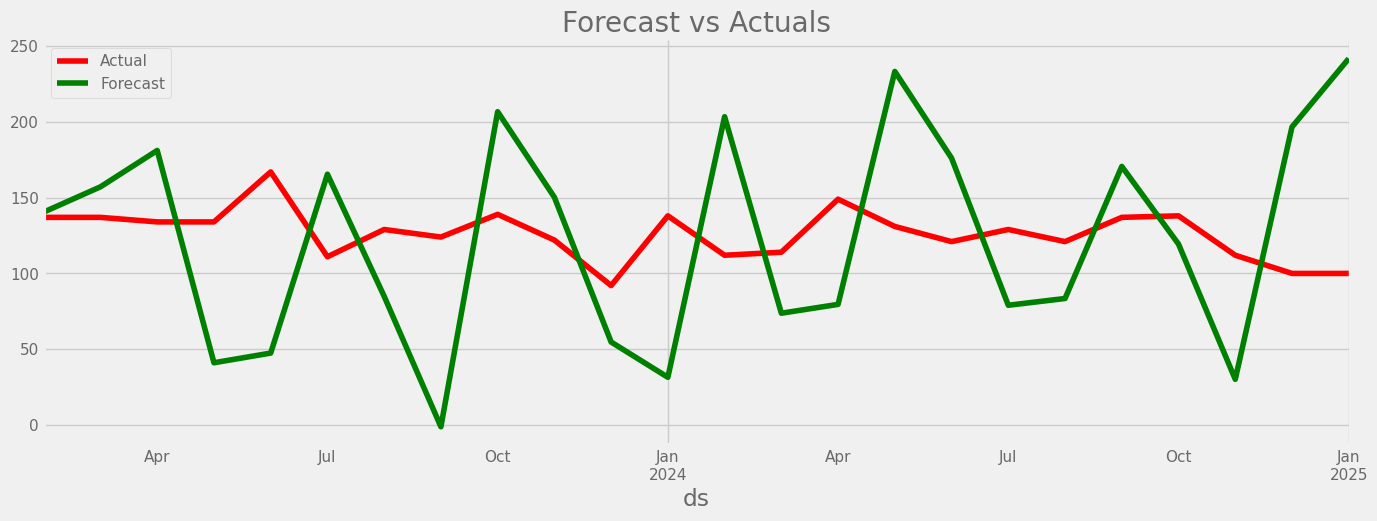

In [69]:
f, ax = plt.subplots(figsize=(14,5))
f.set_figheight(5)
f.set_figwidth(15)
X_tst.plot(kind='line',x='ds', y='y', color='red', label='Actual', ax=ax)
X_tst_final.plot(kind='line',x='ds',y='yhat', color='green',label='Forecast', ax=ax)
plt.title('Forecast vs Actuals')
plt.show()

In [70]:
MAPE = mape(X_tst['y'],abs(X_tst_final['yhat']))
print('MAPE', MAPE)

MAPE 52.98995224388195
